In [597]:
import gzip
import umap
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from IPython.display import clear_output
from tqdm import tqdm
from biomart import BiomartServer

In [2]:
with gzip.open('../data/GSE116222_Expression_matrix.txt.gz', 'rt') as f:
    expr_matrix = pd.read_csv(f, sep='\t', index_col=0)

In [3]:
expression_data = expr_matrix.T

labels = expression_data.index.str.split('-').str[1].to_list()

inflammation_labels = ['UC inflamed' if x.endswith('3') else 'UC non-inflamed' if x.endswith('2') else 'Healthy' for x in labels]
inflammation_labels = pd.Series(inflammation_labels, index=expression_data.index, name='Inflammation')

In [4]:
server = BiomartServer("http://www.ensembl.org/biomart")
mart = server.datasets['hsapiens_gene_ensembl']

response = mart.search({
    'filters': {
        'biotype': 'protein_coding'
    },
    'attributes': [
        'external_gene_name'
    ]
})

In [5]:
protein_coding_genes = [line.strip() for line in response.iter_lines(decode_unicode=True)]
protein_coding_genes = set(protein_coding_genes)

In [6]:
filtered_df = expression_data[[gene for gene in expression_data.columns if gene in protein_coding_genes]]

In [7]:
# drop columns with zero variance
filtered_df = filtered_df.loc[:, filtered_df.var() > 0]

In [598]:
scaled_data = filtered_df.values

In [725]:
def debug_print(selected_genes, model, loss):
    print(f'Genes: {selected_genes}, Loss: {loss.item()}')
    for name, param in model.named_parameters():
        print(f'Parameter name: {name}, Gradient: {param.grad}')

    print('------------------------------------------------------------------')
    print(f'Encoder weights: {model.encoder.weight}')
    print(f'Encoder biases: {model.encoder.bias}')
    print(f'Decoder weights: {model.decoder.weight}')
    print(f'Decoder biases: {model.decoder.bias}')

def plot_learning_curves(training_losses, validation_losses, other_losses=None):
    clear_output(wait=True)

    plt.plot(training_losses, label='Training loss')
    plt.plot(validation_losses, label='Validation loss')
    
    if other_losses:
        for name, loss in other_losses.items():
            plt.plot(loss, label=name)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        # self.encoder = nn.Linear(input_size, hidden_size)
        # self.decoder = nn.Sequential(
        #     nn.Linear(hidden_size, input_size),
        #     nn.ReLU()
        # )
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 124),
            nn.ReLU(),
            nn.Linear(124, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 124),
            nn.ReLU(),
            nn.Linear(124, input_size),
            nn.ReLU()
        )

    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = self.decoder(x)
        return x

# class Autoencoder(nn.Module):
#     def __init__(self, input_size, hidden_size, dropout_rate=0.2):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate)
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(hidden_size, input_size),
#             nn.ReLU()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [ ]:
# # Processing single sample at a time

# # Dataset
# no_samples = scaled_data.shape[0]
# no_genes = scaled_data.shape[1]

# scaled_data_toy = scaled_data[:no_samples, :no_genes]

# X_train, X_test = train_test_split(scaled_data_toy, test_size=0.2, random_state=23)

# X_train = torch.tensor(X_train, dtype=torch.float32)
# X_test = torch.tensor(X_test, dtype=torch.float32)

# # Hyperparameters
# input_size = X_train.shape[1]
# hidden_size = 124
# num_epochs = 10
# learning_rate = 0.001
# masking_value = 0

# # Create the autoencoder model
# model = Autoencoder(input_size, hidden_size)

# # Loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# training_losses = []
# validation_losses = []
# # Training loop
# for epoch in range(num_epochs):
#     epoch_losses = []
#     for sample in X_train:
#         # randomly select how many genes to mask from 1 to 90% of the genes
#         mask = sample != masking_value
#         if mask.sum() < 2:
#             continue

#         non_empty_indexes = torch.nonzero(mask).flatten()
#         no_of_genes_to_mask = np.random.randint(1, int(0.9 * len(non_empty_indexes)))
#         selected_genes = np.random.choice(non_empty_indexes, no_of_genes_to_mask, replace=False)

#         # Corrupt the input data by setting the selected gene to a special value
#         sample_corrupted = sample.clone()
#         sample_corrupted[selected_genes] = masking_value

#         # Forward pass
#         output = model(sample_corrupted)

#         # Compute loss only for the selected genes; put much more weight on genes with non-zero values
#         mask = sample[selected_genes] != masking_value
#         loss = criterion(output[selected_genes][mask], sample[selected_genes][mask])
        
#         epoch_losses.append(loss.item())

#         # Backward pass and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         # debug_print(selected_genes, model, loss)
#         # break
#         optimizer.step()

#     # break

#     # Compute the average loss for the epoch
#     epoch_loss = np.mean(epoch_losses)
#     training_losses.append(epoch_loss)

#     # Compute validation loss
#     with torch.no_grad():
#         val_losses = []
#         for sample in X_test:
#             mask = sample != masking_value
#             if mask.sum() < 2:
#                 continue

#             non_empty_indexes = torch.nonzero(mask).flatten()
#             no_of_genes_to_mask = np.random.randint(1, int(0.9 * len(non_empty_indexes)))
#             selected_genes = np.random.choice(non_empty_indexes, no_of_genes_to_mask, replace=False)

#             sample_corrupted = sample.clone()
#             sample_corrupted[selected_genes] = masking_value

#             output = model(sample_corrupted)
#             mask = sample[selected_genes] != masking_value
#             loss = criterion(output[selected_genes][mask], sample[selected_genes][mask])
#             val_losses.append(loss.item())
            
#         val_loss = np.mean(val_losses)

#     validation_losses.append(val_loss)

#     plot_learning_curves(training_losses, validation_losses)
#     print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss}, Validation loss: {val_loss}') 

In [343]:
class TransformerAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, nhead, num_layers):
        super(TransformerAutoencoder, self).__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead, dim_feedforward=hidden_size),
            num_layers=num_layers
        )
        self.decoder = nn.Linear(input_size, input_size)

    def forward(self, x):
        x = x.unsqueeze(0)  # Add a dimension for sequence length
        x = self.encoder(x)
        x = x.squeeze(0)  # Remove the sequence length dimension
        x = self.decoder(x)
        return x

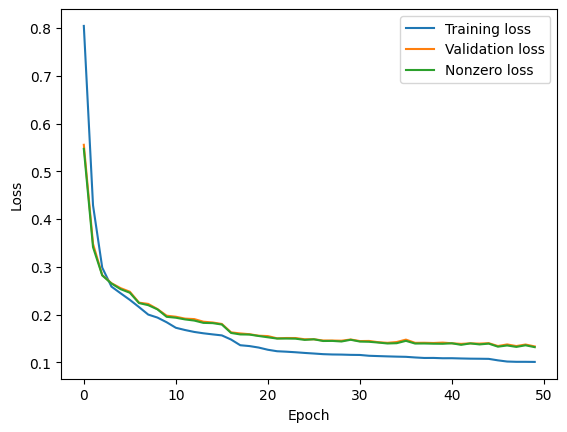

Epoch [49/50], Loss: 0.1010, Val selected loss: 0.1334, Val nonzero loss: 0.1319, Zero loss: 1.0999


In [728]:
# Batch processing

# Dataset
no_samples = scaled_data.shape[0]
no_genes = scaled_data.shape[1]

scaled_data_toy = scaled_data[:no_samples, :no_genes]

X_train, X_test = train_test_split(scaled_data_toy, test_size=0.2, random_state=23)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 124
num_epochs = 50
learning_rate = 0.001
masking_value = 0
batch_size = 32
max_genes_to_mask = 0.8

# Create the autoencoder model
model = Autoencoder(input_size, hidden_size)
# model = TransformerAutoencoder(input_size, hidden_size, nhead=1, num_layers=1)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create data loaders
train_loader = DataLoader(TensorDataset(X_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test), batch_size=batch_size, shuffle=False)

training_losses = []
validation_selected_losses = []
validation_nonzero_losses = []
validation_zero_losses = []
# Training loop
for epoch in range(num_epochs):
    epoch_losses = []
    for batch, in train_loader:
        batch_corrupted = batch.clone()
        for i in range(batch.size(0)):
            # Corrupt the input data by setting the selected gene to a special value
            mask = batch[i] != masking_value
            non_empty_indexes = torch.nonzero(mask).flatten()
            no_of_genes_to_mask = torch.randint(1, int(max_genes_to_mask * len(non_empty_indexes)), (1,))
            selected_genes = non_empty_indexes[torch.randint(len(non_empty_indexes), (no_of_genes_to_mask,))]

            batch_corrupted[i, selected_genes] = masking_value

        # Forward pass
        output = model(batch_corrupted)

        # # Compute loss only for the selected genes
        # loss = criterion(output[batch != batch_corrupted], batch[batch != batch_corrupted])

        # Compute the loss for all non-zero genes in the batch
        mask = batch != masking_value
        loss = criterion(output[mask], batch[mask])
        
        epoch_losses.append(loss.item())

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute the average loss for the epoch
    epoch_loss = np.mean(epoch_losses)
    training_losses.append(epoch_loss)

    # Compute validation loss
    with torch.no_grad():
        val_selected_losses = []
        val_nonzero_losses = []
        zero_losses = []
        for batch, in test_loader:
            batch_corrupted = batch.clone()
            for i in range(batch.size(0)):
                mask = batch[i] != masking_value
                non_empty_indexes = torch.nonzero(mask).flatten()
                no_of_genes_to_mask = torch.randint(1, int(max_genes_to_mask * len(non_empty_indexes)), (1,))
                selected_genes = non_empty_indexes[torch.randint(len(non_empty_indexes), (no_of_genes_to_mask,))]

                batch_corrupted[i, selected_genes] = masking_value

            output = model(batch_corrupted)
            loss = criterion(output[batch != batch_corrupted], batch[batch != batch_corrupted])
            val_selected_losses.append(loss.item())

            # compute loss for all the genes with zero values
            loss = criterion(output[batch == masking_value], batch[batch == masking_value])
            zero_losses.append(loss.item())

            # Compute the loss for all non-zero genes in the batch
            mask = batch != masking_value
            loss = criterion(output[mask], batch[mask])
            val_nonzero_losses.append(loss.item())
            
        val_selected_loss = np.mean(val_selected_losses)
        val_nonzero_loss = np.mean(val_nonzero_losses)
        zero_loss = np.mean(zero_losses)

    validation_selected_losses.append(val_selected_loss)
    validation_nonzero_losses.append(val_nonzero_loss)
    validation_zero_losses.append(zero_loss)

    plot_learning_curves(training_losses, validation_selected_losses, {'Nonzero loss': validation_nonzero_losses})
    print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.4f}, Val selected loss: {val_selected_loss:.4f}, Val nonzero loss: {val_nonzero_loss:.4f}, Zero loss: {zero_loss:.4f}') 

In [665]:
# check the loss of a model that predicts mean value for all the genes; compute the means for each gene separately and use only non-zero values
zero_losses = []
with torch.no_grad():
    means = pd.DataFrame(X_train).replace(masking_value, np.nan).mean(axis=0, skipna=True).to_numpy()
    for sample in X_test:
        mask = sample != masking_value
        loss = criterion(torch.tensor(means[mask], dtype=torch.float32), sample[mask])
        zero_losses.append(loss.item())

nans = np.isnan(zero_losses)
zero_losses = np.array(zero_losses)[~nans]
print(f'Mean zero loss: {np.mean(zero_losses)}')

Mean zero loss: 0.3025082626528603


In [705]:
# Predicting the expression of a specific gene
def predict_gene_expression(data):
    with torch.no_grad():
        output = model(data)
    
    return output

perturbation = 0

# Select a random sample
sample_id = np.random.randint(X_test.shape[0])
test_sample = X_test[sample_id].reshape(1, -1).clone()

# Select a random, non-zero gene
mask = test_sample != masking_value
non_empty_indexes = torch.nonzero(mask[0]).flatten()
gene_index = np.random.choice(non_empty_indexes)

print('Original:', test_sample)
print('Original gene expression:', test_sample[0, gene_index])

test_sample[0, gene_index] = perturbation
print('Perturbed:', test_sample)
print('Perturbed gene expression:', test_sample[0, gene_index])

predicted_expression = predict_gene_expression(test_sample)
print('Predicted:', predicted_expression.detach().numpy())
print('Predicted gene expression:', predicted_expression[0, gene_index])

# compute the loss for all non-zero genes in the sample
mask = test_sample != masking_value
non_empty_indexes = torch.nonzero(mask).flatten()
selected_genes = non_empty_indexes[non_empty_indexes != gene_index]

with torch.no_grad():
    loss = criterion(predicted_expression[0, selected_genes], test_sample[0, selected_genes])

print('Loss:', loss.item())

Original: tensor([[0.0000, 0.9146, 0.0000,  ..., 3.3296, 0.0000, 4.8532]])
Original gene expression: tensor(0.9146)
Perturbed: tensor([[0.0000, 0.9146, 0.0000,  ..., 3.3296, 0.0000, 4.8532]])
Perturbed gene expression: tensor(0.)
Predicted: [[0.8270856 1.0534241 0.8594924 ... 3.142645  1.0310612 4.7192984]]
Predicted gene expression: tensor(1.0481)
Loss: 0.3835766613483429


In [599]:
inflammation_labels_int = inflammation_labels.replace('Healthy', 0).replace('UC non-inflamed', 1).replace('UC inflamed', 2)

reducer = umap.UMAP()
reducer = reducer.fit(scaled_data)

In [ ]:
data_embedding = reducer.transform(scaled_data)

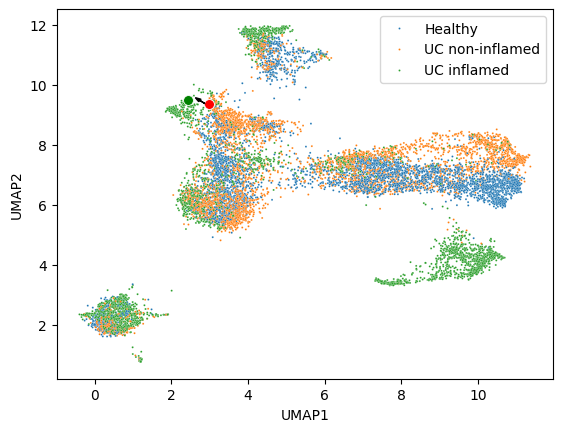

In [817]:
import seaborn as sns

# plot the data
plot_data = pd.concat([pd.DataFrame(data_embedding, index=filtered_df.index, columns=['UMAP1', 'UMAP2']), pd.Series(inflammation_labels).rename('inflammation')], axis=1)

sns.scatterplot(data=plot_data, x='UMAP1', y='UMAP2', hue='inflammation', s=2);

# plot test sample
test_sample = X_test[sample_id].reshape(1, -1).clone()
test_embedding = reducer.transform(test_sample.numpy())
sns.scatterplot(data=pd.DataFrame(test_embedding), x=0, y=1, s=50, color='gray');

# embed and plot perturbed sample
perturbed_sample = test_sample.clone()
perturbed_sample[0, gene_index] = perturbation
perturbed_embedding = reducer.transform(perturbed_sample.numpy())
sns.scatterplot(data=pd.DataFrame(perturbed_embedding), x=0, y=1, s=50, color='red');

# embed and plot predicted sample
predicted_expression = predict_gene_expression(test_sample)
predicted_embedding = reducer.transform(predicted_expression.numpy())
sns.scatterplot(data=pd.DataFrame(predicted_embedding), x=0, y=1, s=50, color='green');

# connect the red point with the green point to show the perturbation with an arrow
plt.arrow(perturbed_embedding[0, 0] - 0.1, perturbed_embedding[0, 1], predicted_embedding[0, 0] - perturbed_embedding[0, 0] + 0.4, predicted_embedding[0, 1] - perturbed_embedding[0, 1], color='black', head_width=0.1);

In [892]:
# predict the expression of all genes for all samples in filtered_df
predicted_data = predict_gene_expression(torch.tensor(filtered_df.values, dtype=torch.float32)).detach().numpy()

In [894]:
predicted_reducer = umap.UMAP()
predicted_reducer = predicted_reducer.fit(predicted_data)

predicted_data_embedding = predicted_reducer.transform(predicted_data)

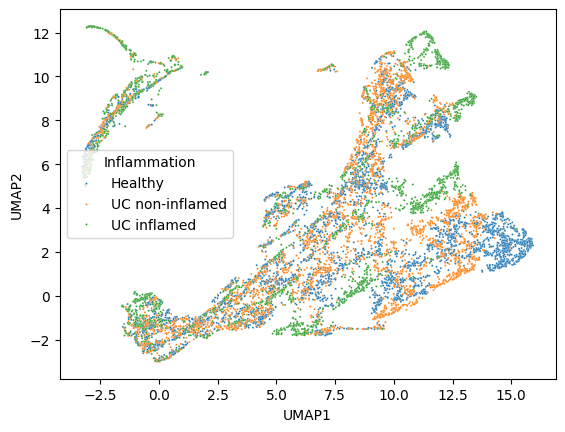

In [1024]:
plot_data = pd.concat([pd.DataFrame(predicted_data_embedding, index=filtered_df.index, columns=['UMAP1', 'UMAP2']), pd.Series(inflammation_labels).rename('Inflammation')], axis=1)

sns.scatterplot(data=plot_data, x='UMAP1', y='UMAP2', hue='Inflammation', s=2);

In [1038]:
# randomly select a gene
gene_index = np.random.randint(X_train.shape[1])
gene_name = filtered_df.columns[gene_index]
print(f'Gene name: {gene_name}')
# randomly select a healthy sample from filtered_df
sample_id = np.random.choice(filtered_df.index[inflammation_labels == 'Healthy'])
test_sample = torch.tensor(filtered_df.loc[sample_id].values, dtype=torch.float32).reshape(1, -1)
perturbed_sample = test_sample.clone()

cell_states = []
predicted_expression = predict_gene_expression(perturbed_sample)
cell_states.append(predicted_expression)
for i in range(100):
    perturbed_sample[0, gene_index] = perturbed_sample[0, gene_index] - 0.1

    predicted_expression = predict_gene_expression(perturbed_sample)

    # break if previous expression is very similar to any of the previous expressions
    if torch.allclose(predicted_expression, cell_states[-1], atol=1e-5) and predicted_expression[0, gene_index] <= 0:
        break

    cell_states.append(predicted_expression)

cell_states = torch.cat(cell_states, dim=0)

cell_states_embedding = predicted_reducer.transform(cell_states.numpy())

Gene name: SPOPL


In [1027]:
# print the gene name
gene_name = filtered_df.columns[gene_index]
print(f'Gene name: {gene_name}')

Gene name: TMLHE


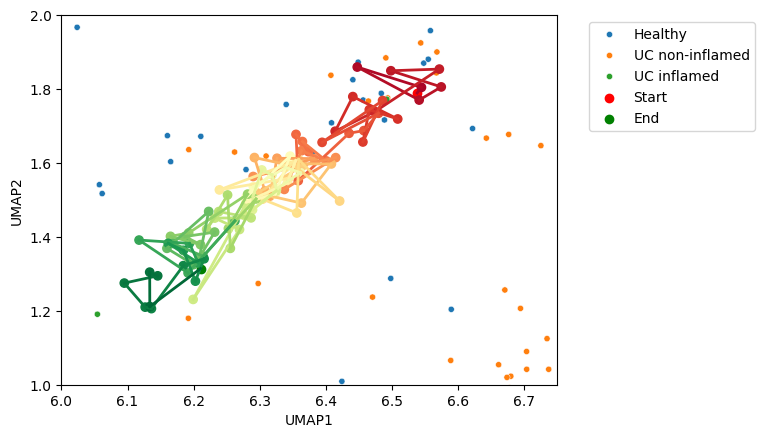

In [1047]:
sns.scatterplot(data=plot_data, x='UMAP1', y='UMAP2', hue='Inflammation', s=20);

# plot a path following the cell states, coloring each edge and state from red to green, but don't add the colors to the legend
colors = np.linspace(0, 1, cell_states_embedding.shape[0])
plt.scatter(cell_states_embedding[0, 0], cell_states_embedding[0, 1], color='red', label='Start')
plt.scatter(cell_states_embedding[-1, 0], cell_states_embedding[-1, 1], color='green', label='End')
plt.scatter(cell_states_embedding[1:-1, 0], cell_states_embedding[1:-1, 1], color=plt.cm.RdYlGn(colors[1:-1]))

# plot lines connecting the cell states, coloring each edge from red to green
for i in range(1, cell_states_embedding.shape[0]):
    plt.plot([cell_states_embedding[i-1, 0], cell_states_embedding[i, 0]], [cell_states_embedding[i-1, 1], cell_states_embedding[i, 1]], color=plt.cm.RdYlGn(colors[i]), linewidth=2)

# move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');

# zoom in on the path
plt.xlim(6, 6.75)
plt.ylim(1, 2);

# save the plot to a file
plt.savefig('path_zoom.png', dpi=300, bbox_inches='tight')

In [707]:
# predict the expression for all samples in the test set and embed them
predicted_expressions = []
for sample in X_test:
    predicted_expression = predict_gene_expression(sample.reshape(1, -1))
    predicted_expressions.append(predicted_expression.numpy())

In [708]:
predicted_expressions = np.array(predicted_expressions).squeeze()
predicted_embeddings = reducer.transform(predicted_expressions)

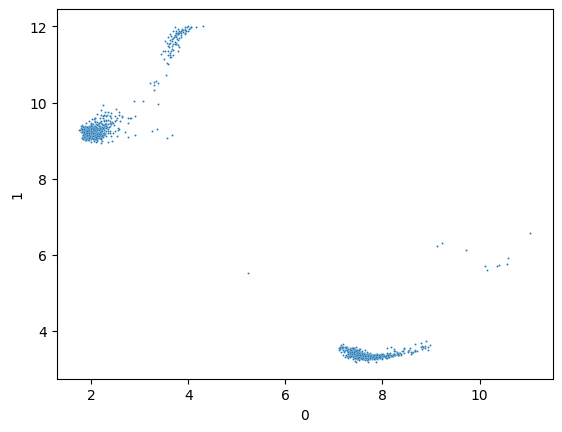

In [711]:
# plot the embeddings

sns.scatterplot(data=pd.DataFrame(predicted_embeddings), x=0, y=1, s=2);

In [724]:
# from filtered_df, remove genes appearing in less than 100 samples and samples with less than 10 genes
asdf = filtered_df.loc[:, filtered_df.columns[filtered_df.sum() > 100]]

asdf.shape

(11175, 10455)

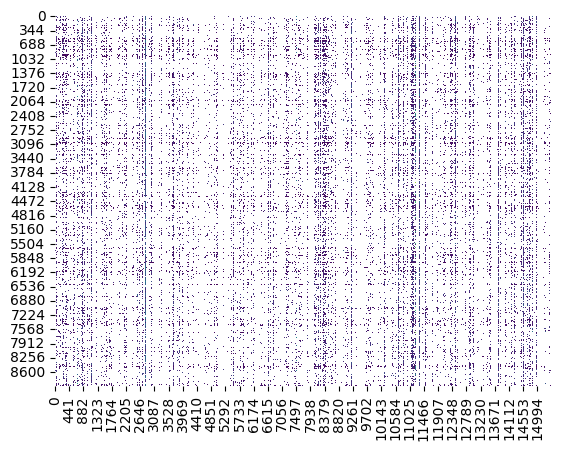

In [627]:
# plot the non-zero values in the data, each sample; x axis = samples, y axis = genes
non_zero_values = pd.DataFrame(X_train.numpy()).replace(masking_value, np.nan)
sns.heatmap(non_zero_values, cmap='viridis', cbar=False);

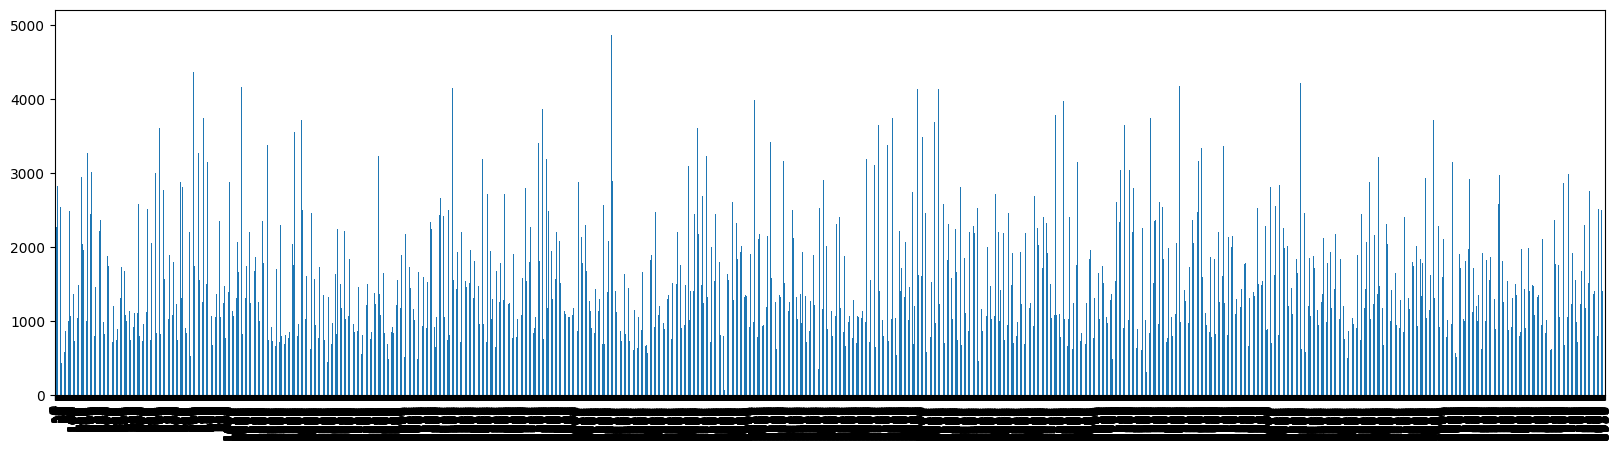

In [645]:
# now, draw a bar plot for each sample, showing the number of non-zero values, ordered decreasingly by the number of non-zero values
non_zero_values_count = non_zero_values.count(axis=1)
# non_zero_values_count = non_zero_values_count.sort_values(ascending=False)
non_zero_values_count.plot(kind='bar', figsize=(20, 5));
plt.title('Number of non-zero values in each sample');

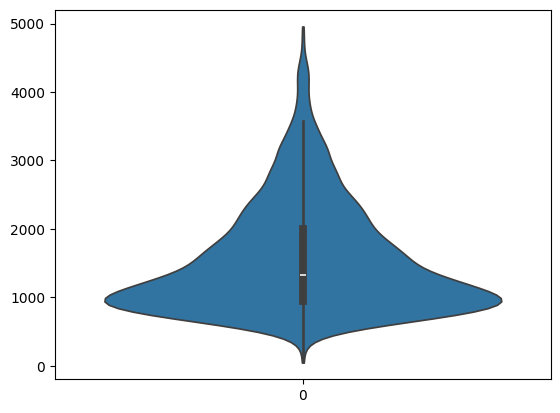

In [664]:
non_zero_values_count = non_zero_values.count(axis=1)
non_zero_values_count = non_zero_values_count
sns.violinplot(data=non_zero_values_count.to_frame(), cut=0);

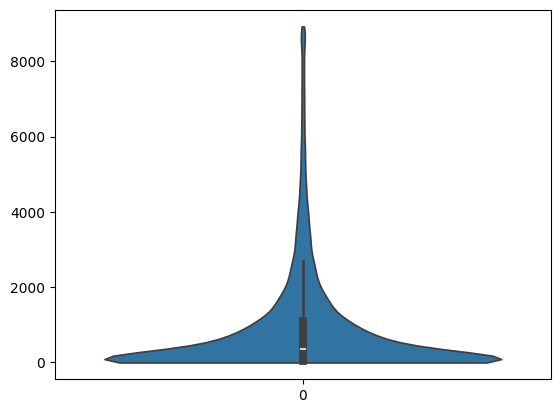

In [663]:
non_zero_values_count = non_zero_values.count(axis=0)
non_zero_values_count = non_zero_values_count
sns.violinplot(data=non_zero_values_count.to_frame(), cut=0);

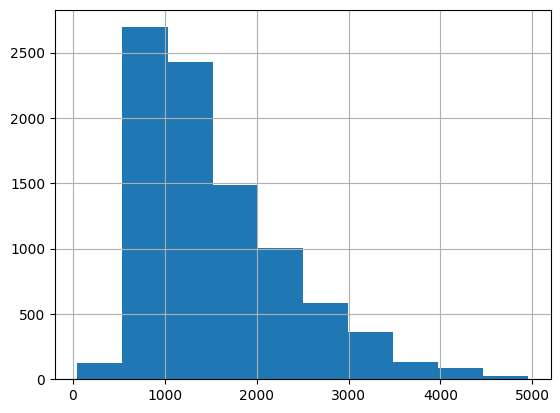

In [631]:
non_zero_values_count.hist();